In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
# step 1

CANT_ENTRENAMIENTO=800
CANT_PRUEBAS=200
TOTAL = CANT_ENTRENAMIENTO+CANT_PRUEBAS
USAR_MASK = True
mask = ""
if USAR_MASK:
    mask = "_with_mask"

filenames = []
labels = []

for i in range(1,TOTAL+1):
    for type in ['COVID','Normal']:
        filenames.append(f'./dataset/{type}/images{mask}/{type}-{i}.png')
        labels.append(1 if type == 'COVID' else 0)

filenames_train = filenames[0:CANT_ENTRENAMIENTO*2]
labels_train = labels[0:CANT_ENTRENAMIENTO*2]

filenames_test = filenames[CANT_ENTRENAMIENTO*2:TOTAL*2]
labels_test = labels[CANT_ENTRENAMIENTO*2:TOTAL*2]

In [4]:
# step 2: create a dataset returning slices of `filenames`
datos_train = tf.data.Dataset.from_tensor_slices((filenames_train, labels_train))
datos_test = tf.data.Dataset.from_tensor_slices((filenames_test, labels_test))

In [5]:
#Obtenemos en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento, datos_pruebas = datos_train, datos_test
datos_entrenamiento

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [6]:
nombres_clases = ['normal','covid']
nombres_clases


['normal', 'covid']

In [7]:
#Funcion de normalizacion para los datos (Pasar de 0-255 a 0-1)
#Hace que la red aprenda mejor y mas rapido

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_image(image_string, channels=0)
  image = tf.cast(image_decoded, tf.float32)
  image /= 255 
  return image, label

#Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(_parse_function)
datos_pruebas = datos_pruebas.map(_parse_function)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

2022-09-27 11:23:05.943129: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


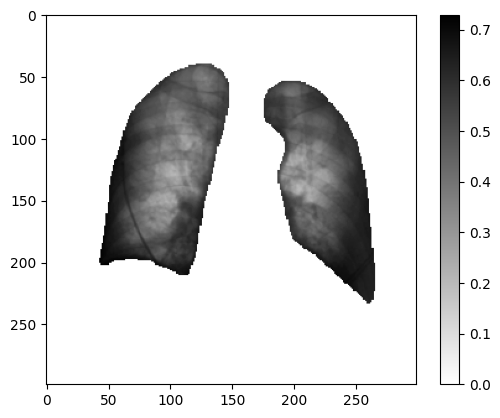

In [8]:
#Mostrar una imagen de los datos de pruebas, de momento mostremos la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((299,299)) #Redimensionar, cosas de tensores, lo veremos despues# imagen = imagen.numpy().reshape((28,28)) #Redimensionar, cosas de tensores, lo veremos despues

import matplotlib.pyplot as plt

#Dibujar dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()


In [ ]:
#Dibujar mas
plt.figure(figsize=(10,10))
# for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((299,299))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()


In [ ]:
#Crear el modelo
modelo = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(), #1 - blanco y negro
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
  #tf.keras.layers.Dense(10, activation=tf.nn.sigmoid) #Para redes de clasificacion
])

In [ ]:
#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
# #Los numeros de datos en entrenamiento y pruebas (60k y 10k)
num_ej_entrenamiento = CANT_ENTRENAMIENTO
num_ej_pruebas = CANT_PRUEBAS

In [ ]:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

In [ ]:
#El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
TAMANO_LOTE = 32

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [ ]:
import math
#Entrenar
historial = modelo.fit(datos_entrenamiento, epochs=60,batch_size=TAMANO_LOTE, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE),validation_data = datos_pruebas,validation_batch_size=TAMANO_LOTE, validation_steps=math.ceil(num_ej_pruebas/TAMANO_LOTE))

In [ ]:
#Ver la funcion de perdida
import matplotlib.ticker as mtick
plt.xlabel("# Epoca")
plt.ylabel("Accuracy")
ax = plt.plot(historial.history["accuracy"])
ax = plt.plot(historial.history["val_accuracy"])


In [ ]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.rint(arr_predicciones[0]).astype(int)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(1), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.rint(arr_predicciones).astype(int)
  if etiqueta_real==etiqueta_prediccion: 
    grafica[0].set_color('blue')
  else:
    grafica[0].set_color('red')
  
filas = 4
columnas = 8
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [ ]:
#Probar una imagen suelta
imagen = imagenes_prueba[4] #AL ser la variable imagenes_prueba solo tiene lo que se le puso en el bloque anterior heheh
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])